* Bergamasco Alex, 920227 
* Di Giusto Federico, 920847
* LEADERBOARD NICKNAME: BrovadaTeam

# ANNDL_Homework3 : Visual Question Answering

### Approach

In the first phase, we developed the custom generator that permits to generate batches in a correct way for the network.  
In the custom generator we did the tokenization and padding of the questions using  tf.keras.preprocessing tools.   
  
  

The main structure of our Neural Network model was decided from the beggining.  
We began initially with a fine-tuning vgg16, and two basic LSTM layer for the question input. The tail of the ntw is built with Dense-Drop-Dense layers. 
The accuracy, from the beggining, was about 0.44, so we decided to mantain this basic structure and to focus on this.  
  
  
The compilation was likely standard, using Adam optimizer (lr=1e-03 / 1e-04) and CategorigalCrossentropy (as we used one-hot rapresentation for the target).

#### VGG
We improved our model using vgg19. In particular, we add all its layers pre-trained not trainable. We added a AveragePooling and a Dense layer.  
For this part, we made an alternative tentative. Infact, we try to add only the first layers (about 5) not-trainable, and to leave the other trainable. The intuition point of this tentative was that we thought that the first layers of vgg were better to capture the big features of our dataset images and then leaving the other to be trained for the smaller features. 
At the end, this tentative didn't reach a good result.

#### RNN
Initially we used LSTM layers and Dropout layers.
In a second moment, we perceived that this part was less powerful then the vgg part. Therefore, for building a RNN with a more long range dependicies, we made Bidirectional the first LSTM layer.This layer permits to propagate input in the RNN.  
This changement improves the accuracy of the model.

### Code structure:
* 1) Dataset Creation
    * Tokenizetion
    * Custom Generator
* 2) Model Creation
    * VGG
    * RNN
    * Ending Part
* 3) Compiling Model
* 4) Making predictions
 

### Structure of the Neural Network:

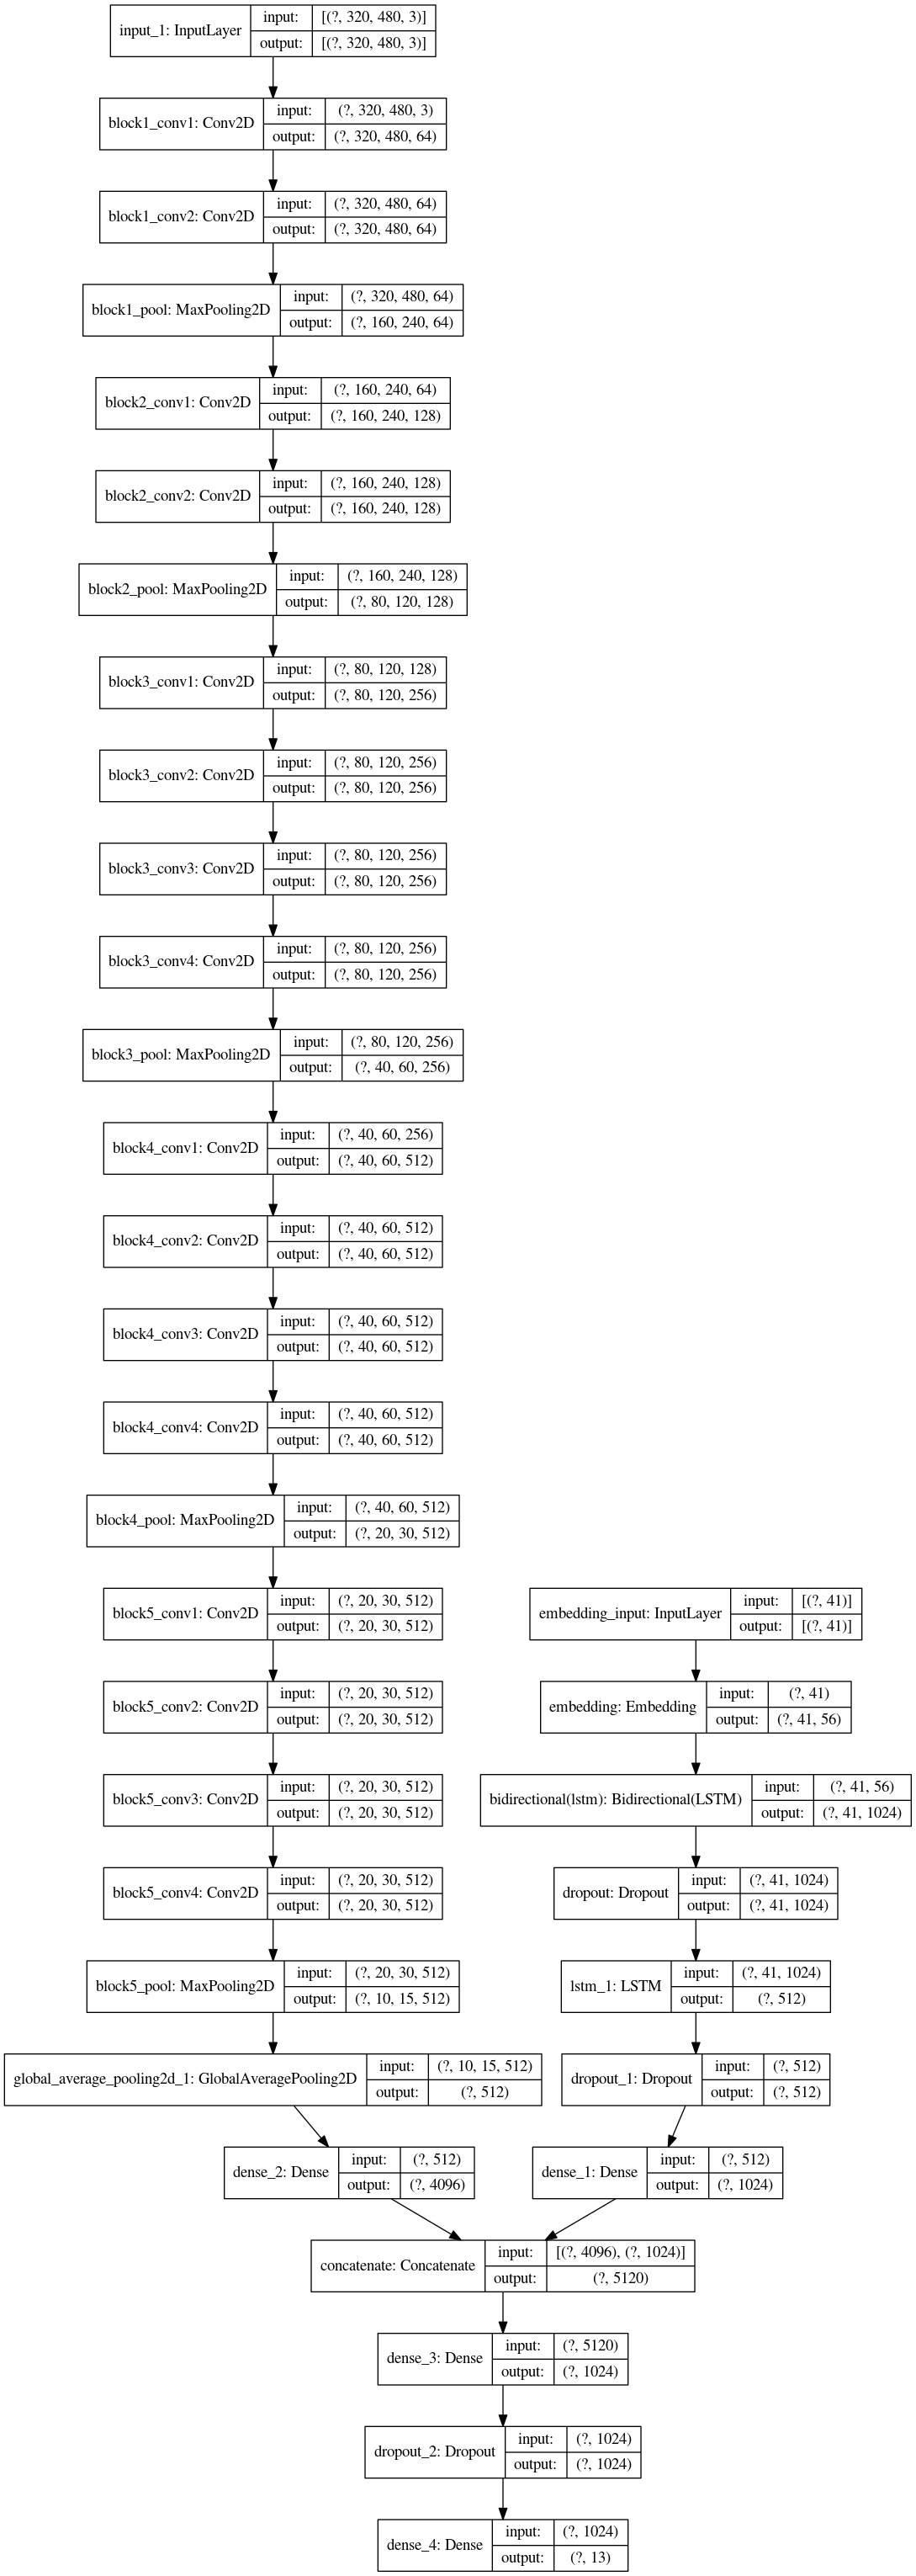

In [25]:
plot_model(model_final,show_shapes=True, show_layer_names=True)

### Code

In [7]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Fixed seed to reproduce computation
SEED = 1234
tf.random.set_seed(SEED)  


cwd = os.getcwd()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# 1) Dataset Creation

In [8]:
import json

img_h = 320
img_w = 480


path_dataset='/kaggle/input/ann-and-dl-vqa/dataset_vqa'

with open(path_dataset+'/train_data.json', 'r') as f:
      SUBSET_data = json.load(f)
f.close()

files=SUBSET_data['questions']

Switch case to set the correct answer

In [9]:
switcher = {
    '0': 0,
    '1': 1,
    '10': 2,
    '2': 3,
    '3': 4,
    '4': 5,
    '5': 6,
    '6': 7,
    '7': 8,
    '8': 9,
    '9': 10,
    'no': 11,
    'yes': 12
}

### Tokenization

In [10]:
questions = []

for e in files:
    questions.append(e['question'])

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 70

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(questions)
tokenized = tokenizer.texts_to_sequences(questions)

wtoi = tokenizer.word_index
print('Total words:', len(wtoi))

max_questions_length = max(len(sentence) for sentence in tokenized)
print('Max sentence length:', max_questions_length)

Total words: 70
Max sentence length: 41


In [12]:
padded_inputs = pad_sequences(tokenized, maxlen=max_questions_length)

 Substitute the tokenized version into vector 'files'

In [13]:
for i in range(0,len(files)):
    files[i]['question']=padded_inputs[i]

### Custom Generator

We have created a custom generator in order to retrieve from the dataset the corresponding Image-Question-Answer block. 
In the generator we create the batches of inputs.






To read the image we have used cv2 library.

In [14]:
import cv2

def retrieve_image(path):
    x = '/kaggle/input/ann-and-dl-vqa/dataset_vqa/' + path
    img = cv2.imread(x)
    return(img)

Method that generates the one_hot answer for classification.

In [15]:
def decode_one_hot(data, num_classes=13):
    zer = np.zeros((num_classes,),dtype=float)
    zer[data] = 1 
    return zer

In [17]:
def batch_generator(files, batch_size = 56):
    
    while True:
        
        batch_paths = np.random.choice(a = files, size = batch_size)
        X_images_input = []
        X_question_input = []
        y_output = []
        
        for el in batch_paths: 
            x_question=el['question']
            y_answer=switcher.get(el['answer'],0)
            y_answer=decode_one_hot(y_answer)
            
            x_image = retrieve_image('train/'+el['image_filename'])
            
            X_images_input = X_images_input + [ x_image ]
            X_question_input = X_question_input + [ x_question ] 
            y_output = y_output + [y_answer]
            
        X_images_batch = np.array( X_images_input )
        X_questions_batch = np.array( X_question_input )
        y_batch = np.array( y_output )
        
          
        yield ([X_images_batch, X_questions_batch], y_batch)

In [18]:
import random

files=np.array( files )

random.shuffle(files)

Split train dataset into Train and Validation (numbers are computed considering 70%-30% splitting)

In [19]:
train_files=files[0:181643]
val_files=files[181643:len(files)]

len(train_files)+len(val_files)

259492

Create the two generators: Train Generator and Batch Generator

In [20]:
train_gen=batch_generator(train_files)
valid_gen=batch_generator(val_files)

# 2) Model creation

We create our model using a Convolutional Neural Network for the image data processing and a Recurrent Neural Network for text data processing.

For the CNN part, at first we made a fine-tuning with a pretrained VGG16 (without top layers). We got a good accuracy but we decided to switch to VGG19. This little change gives a plus 0.02 accuracy (considering unchanged the RNN part of the network).

All the VGG layers are not trainable in our network.


For the RNN part, the model is mainly structured with two LSTM. 
The first LSTM layer is enforced by the Bidirectional layer, that permits to learn more long range dependiese. In particular, this addition to the model improves the accuracy of the model.
Dropout of 0.5 was added between LSTM layers.


### VGG19 - Import

In [4]:
VGG = tf.keras.applications.VGG19(input_shape=(img_h, img_w, 3), include_top=False)

80142336/80134624 [==============================] - 3s 0us/step


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model = Sequential()
for layer in VGG.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(4096, activation='relu'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 320, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 120, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 80, 120, 256)     

### RNN - LSTM

In [21]:
embedding_dim = 56

mod =tf.keras.Sequential()
mod.add(tf.keras.layers.Embedding(len(wtoi)+1, embedding_dim, input_length=max_questions_length))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, return_sequences=True, input_shape=(max_questions_length, embedding_dim))))
mod.add(tf.keras.layers.Dropout(0.5))
mod.add(tf.keras.layers.LSTM(units=512, return_sequences=False))
mod.add(tf.keras.layers.Dropout(0.5))
mod.add(tf.keras.layers.Dense(1024, activation='tanh'))

mod.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 56)            3976      
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 1024)          2330624   
_________________________________________________________________
dropout (Dropout)            (None, 41, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
Total params: 6,007,688
Trainable params: 6,007,688
Non-trainable params: 0
____________________________________________

 ### Concatenation CNN+RNN
 

In [23]:
from keras.layers.merge import Concatenate

combined = tf.keras.layers.concatenate([model.output, mod.output])

Using TensorFlow backend.


### Endig part of the n.n.

After concatenation, we added two dense layers and a dropout.   
Relu as activation function performs better w.r.t. tanh in our model.


At the end, softmax activation for the classification of the task (num_classes = number of possible answers)

In [24]:
num_classes=13

model_all=tf.keras.layers.Dense(units=1024, activation='relu')(combined)
model_all=tf.keras.layers.Dropout(0.2)(model_all)
model_all = tf.keras.layers.Dense(units=num_classes, activation='softmax')(model_all)

model_final = tf.keras.Model(inputs=[model.input, mod.input], outputs=model_all)

In [ ]:
model_final.summary()

In [ ]:
plot_model(model_final,show_shapes=True, show_layer_names=True)

# 3) Compiling Model

### Parameters
Standard techniques were applied for this section of the code.
During the running of our best kaggle score, we have changed the learning-rate from 1e-3 to 1e-4 for the third and fourth epoch. This was done beacuse we noticed that the accuracy was likely stable (withouth improvement) and with high steps of changing.

In addition, we shuffled the dataset among epochs, for changing validation and training dataset.

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy']

model_final.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
model_final.fit_generator(train_gen,
                          epochs=4,
                          steps_per_epoch=3244, #len(train)/batch_size
                          validation_data=valid_gen,
                          validation_steps=1391, #len(val)/batch_size
                          callbacks=None)

# 4) Making predictions

At first, we create the test dataset.   
Operations are similar to the ones in the train set.  


Then, we perform predictions and create the .csv file for the submission.

In [ ]:
import json

path_dataset='/kaggle/input/ann-and-dl-vqa/dataset_vqa'

with open(path_dataset+'/test_data.json', 'r') as f:
      TEST_data = json.load(f)
f.close()

test_json=TEST_data['questions']

In [ ]:
questions = []

for e in test_json:
    questions.append(e['question'])

In [ ]:
tokenized = tokenizer.texts_to_sequences(questions)
padded_question = pad_sequences(tokenized, maxlen=max_questions_length)

In [ ]:
for i in range(0,len(test_json)):
    test_json[i]['question']=padded_question[i]

In [ ]:
results={}
i=0
for el in range(0,len(test_json)):
    
    img=retrieve_image('test/'+test_json[el]['image_filename'])
    question=test_json[el]['question']
    question_id=test_json[el]['question_id']
    
    img=np.array(img)
    img = np.expand_dims(img, 0) 
    
    question=np.array(question)
    question = np.expand_dims(question, 0) 
    
    out_softmax = model_final.predict(x=[img,question])
    
    predicted_class = np.argmax(out_softmax, -1)
    predicted_class = predicted_class[0]
    
    results[question_id]=predicted_class
    
    i=i+1
    if(i%300==0):
        print('Done {}/{} predictions'.format(i,len(test_json)))
    

 Create csv

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

In [ ]:
create_csv(results)